In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import matplotlib.pyplot as plt, numpy as np, math

h = lambda p : -p*np.log2(p) -(1-p)*np.log2(1-p)

In [19]:
h(1/2)

1.0

In [22]:
math.log2(2)

1.0

C:\Users\joaquimg\AppData\Local\Temp\ipykernel_13724\2748804848.py:3: RuntimeWarning: divide by zero encountered in log2
  h = lambda p : -p*np.log2(p) -(1-p)*np.log2(1-p)
C:\Users\joaquimg\AppData\Local\Temp\ipykernel_13724\2748804848.py:3: RuntimeWarning: invalid value encountered in multiply
  h = lambda p : -p*np.log2(p) -(1-p)*np.log2(1-p)


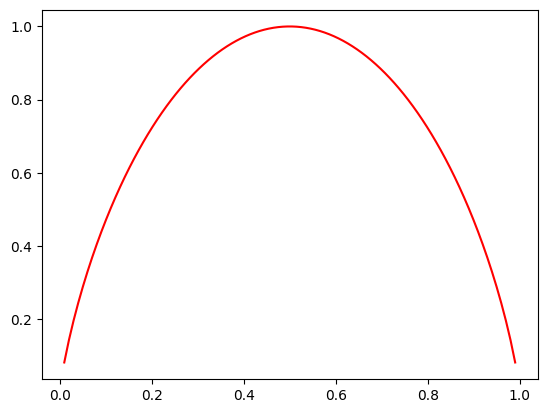

In [21]:
x = np.linspace(0, 1, 100)

plt.plot(x, h(x), color='red')

In [2]:
import sys, matplotlib.pyplot as plt, numpy as np, pandas as pd, pyomo.environ as pyo, pyomo, glob, os
from io import StringIO

plt.rcParams['text.usetex'] = True

sys.path.append('../Teaching/')
import draw_MILO as milo
import draw_SP as sp

pyomo.__version__

'6.4.2'

In [3]:
overleaf_path = r'D:\joaquimg\Dropbox\Apps\Overleaf\Possible Exam Questions/'
milo.SetOutputPath( overleaf_path+'generated' )
main_path = milo._output_path
sp.SetOutputPath( milo._output_path+'sp' )
milo.SetOutputPath( milo._output_path+'milo' )

In [4]:
def GetNodesAndEdgesAsFromLecture():
    nodes = '''
node;x;y;color;label;legend
A;0;1
B;2;2
C;5;2
D;2;0
E;5;0
'''

    edges = '''
from;to;length;color
A;B;10
A;D; 5
B;C; 1
B;D; 2
C;E; 4
D;B; 3
D;C; 9
D;E; 2
E;A; 7
E;C; 6
'''

    return pd.read_csv(StringIO(nodes), sep=";",index_col='node'), \
        pd.read_csv(StringIO(edges), sep=";",index_col=['from','to'])

In [5]:
def GetNodesAndEdgesGraph9():
    nodes = '''
node;x;y;color;label;legend
1;0;1
2;0;3
3;0;5
4;3;1
5;3;3
6;3;5
7;6;1
8;6;3
9;6;5
'''

    edges = '''
from,to,length,color
1,2,1
6,2,2
1,4,3
2,3,5
2,4,1
2,5,3
3,6,2
4,5,1
5,6,2
5,8,2
6,8,3
6,9,3
8,9,1
7,4,1
7,5,5
7,8,3
'''

    return pd.read_csv(StringIO(nodes), sep=";",index_col='node',dtype={'node': str}), \
        pd.read_csv(StringIO(edges), sep=",",index_col=['from','to'],dtype={'from': str,'to': str})

In [6]:
def ThisGraph( nodes, edges, name, s, t, type_length=int ):
    old_path = sp._output_path
    sp.SetOutputPath( sp._output_path + f'{name}-{s}-{t}' )
    sp.DrawIntoFile( sp.MakeGraph( nodes, edges, type_length), name+'.pdf' )
    sp.PoorManDijkstra( nodes,edges,s,t,sp.DrawIntoPDF,name+'_' )
    _,result = sp.PoorManDijkstraReuse( nodes,edges,s,t,sp.DrawIntoPDF,name+'_reuse')
    file_name = sp._output_path+name+'_description.txt'
    with open(file_name, "w") as text_file:
        text_file.write('\n'.join(result))
    sp.SetOutputPath( old_path )
        
def SectionSP( name, s, t ):
    folder_name = rf'{name}-{s}-{t}'
    mask = sp._output_path+ rf'{folder_name}\*.pdf'
    files = sorted( [ os.path.split(f)[-1] for f in glob.glob(mask) ] )
    
    parts = []
    
    parts.append( fr'''\newpage
\section{{{name} from {s} to {t}}}

\begin{{question}}
Compute the shortest path from {s} to {t}
$$
\includegraphics[scale=.8]{{generated/sp/{folder_name}/{files[0]}}}
$$
\end{{question}}

\begin{{solution}}

First we show the resolution step by step, each step on its own graph.
''' )
    
    for file in files[1:-1]:
        parts.append( fr'''
\includegraphics[scale=.8]{{generated/sp/{folder_name}/{file}}}
''')
        
    parts.append( fr'''
Now we draw the resolution on a single graph, updating the labels on the nodes. 

\includegraphics[scale=.8]{{generated/sp/{folder_name}/{files[-1]}}}
''')
    
    parts.append( fr'''   
Below the step by step description of the algorithm application.
{{\scriptsize
\lstinputlisting[breaklines,language={{}},frame={{}},backgroundcolor=\color{{white}}]{{generated/sp/{folder_name}/{name}_description.txt}}
}}''')
    
    parts.append( fr'''
\end{{solution}}''')
 
    return '\n'.join( parts )

In [7]:
sp_exercises = { ('g9', '1', '9') : GetNodesAndEdgesGraph9,
                 ('g9', '1', '6') : GetNodesAndEdgesGraph9,
                 ('abw-example', 'A', 'C') : GetNodesAndEdgesAsFromLecture,
                }

In [8]:
for (name,s,t), generator in sp_exercises.items():
    ThisGraph( *generator(), name, s, t )

In [9]:
sections = [ SectionSP( *key ) for key in sp_exercises.keys() ]

In [10]:
with open(main_path+'all_sp.tex', "w") as tex_file:
    tex_file.write('\n'.join(sections))

In [11]:
def ThisModel( m ):
    old_path = milo._output_path
    milo.SetOutputPath( milo._output_path + m.name )
    milo.Draw( m, isolines=True, file_name=m.name+'-isolines.pdf' )
    milo.Draw( m, isolines=False, file_name=m.name+'.pdf' )
    milo.Draw( m, isolines=True, integer=True, file_name=m.name+'-isolines-integer.pdf' )
    milo.Draw( m, isolines=False, integer=True, file_name=m.name+'-integer.pdf' )
    with open(milo._output_path+m.name+'.tex', "w") as text_file:
        text_file.write(milo.to_latex(m))
    milo.SetOutputPath( old_path )
        
def Section( m ):
    return fr'''\newpage
\section{{{m.name}}}

\begin{{question}}
$$
\input{{generated/milo/{m.name}/{m.name}}}
$$
\end{{question}}

\begin{{solution}}

\begin{{figure}}[H]
\centering
\includegraphics[scale=.8]{{generated/milo/{m.name}/{m.name}-isolines.pdf}}
\caption{{Linear with isolines on all basic feasible solutions}}
\end{{figure}}

\begin{{figure}}[H]
\centering
\includegraphics[scale=.8]{{generated/milo/{m.name}/{m.name}.pdf}}
\caption{{Linear with isoline on optimal basic feasible solution}}
\end{{figure}}

\begin{{figure}}[H]
\centering
\includegraphics[scale=.8]{{generated/milo/{m.name}/{m.name}-integer.pdf}}
\caption{{Linear with latice of integer solutions}}
\end{{figure}}

\begin{{figure}}[H]
\centering
\includegraphics[scale=.8]{{generated/milo/{m.name}/{m.name}-isolines-integer.pdf}}
\caption{{Linear with latice of integer solutions all isolines on all basic feasible solutions of the linear relaxation}}
\end{{figure}}

\end{{solution}}'''

In [12]:
def Ex( A, b, c, is_min, name ):
    assert len(c) == 2
    assert A.shape[0] == len(b)
    assert A.shape[1] == len(c)
    assert len(c.shape) == 1
    assert len(b.shape) == 1
    
    idx = np.where( b < 0 )
    A[idx,:] *= -1
    b[idx] *= -1
    
    m   = pyo.ConcreteModel(name)
    
    m.I = pyo.RangeSet( len(c) )
    m.J = pyo.RangeSet( len(b) )
    
    m.x = pyo.Var( m.I, within=pyo.NonNegativeReals )

    @m.Objective( sense = pyo.minimize if is_min else pyo.maximize )
    def obj(m):
        return sum( c[i-1]*m.x[i] for i in m.I )

    @m.Constraint(m.J) 
    def constraint_u(m, j): 
        if j-1 in idx[0]:
            return sum( A[j-1,i-1]*m.x[i] for i in m.I ) >= b[j-1]
        return sum( A[j-1,i-1]*m.x[i] for i in m.I ) <= b[j-1]
    
    return m
    

In [13]:
np.random.seed(2022)
for i in range(0):
    c = np.random.randint(-3,3,2)
    A = np.random.randint(-2,2,(3,2))
    b = np.random.randint(-2,8,3)
    if milo.GetBasicSolutions(A,b).shape[-1] < len(b):
        continue
    if milo.GetBasicFeasibleSolutions(A,b).shape[-1] < len(c):
        continue
    m = Ex(A,b,c,True,'test')
    milo.Draw(m)

In [14]:
models = [
    Ex( np.array([[1,2],[-4,-3],[3,1]]), np.array([8,-5,7]), np.array([2,1]), False, 'maximizing with 8 int sol'),
    Ex( np.array([[1,2],[-4,-3],[3,1]]), np.array([8,-5,7]), np.array([2,1]), True, 'minimizing with 8 int sol'),
    Ex( np.array([[1,2],[-2,-3],[3,1]]), np.array([3,-2,3]), np.array([2,1]), False, 'maximizing with 2 int sol'),
    Ex( np.array([[1,2],[-2,-3],[3,1]]), np.array([3,-2,3]), np.array([2,1]), True, 'minimizing with 2 int sol'),
    Ex( np.array([[1,2],[-2,-3],[3,1]]), np.array([1,-1,1]), np.array([2,1]), False, 'maximizing with no int sol'),
    Ex( np.array([[1,2],[-2,-3],[3,1]]), np.array([1,-1,1]), np.array([2,1]), True, 'minimizing with no int sol'),
    Ex( np.array([[2,1],[3,5],[1,5]]), np.array([3,7,5]), np.array([1,2]), False, 'maximizing with 3 int sol'),
    Ex( np.array([[2,1],[3,5],[1,5]]), np.array([3,7,5]), np.array([1,2]), True, 'minimizing with 3 int sol'),
    Ex( np.array([[1,2],[-2,-3]]), np.array([1,-1]), np.array([3,2]), False, 'maximizing with 1 int sol'),
    Ex( np.array([[1,2],[-2,-3]]), np.array([1,-1]), np.array([3,2]), True, 'minimizing with 1 int sol')
]

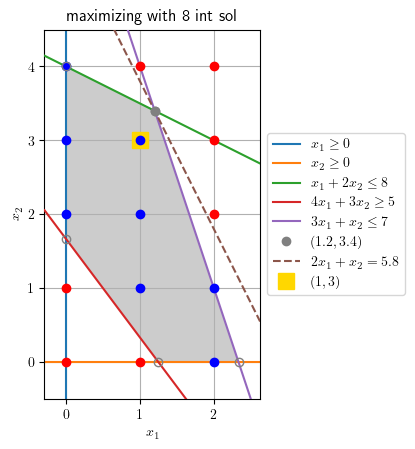

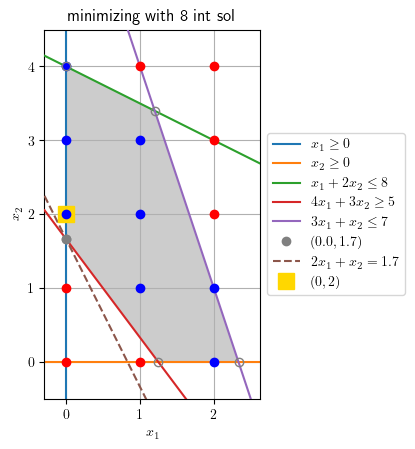

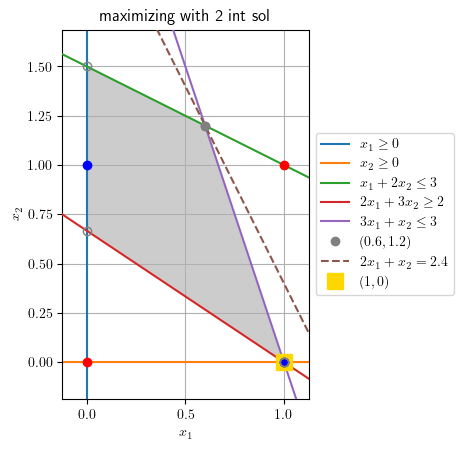

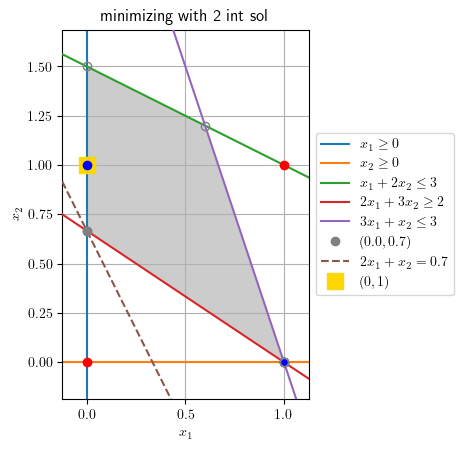

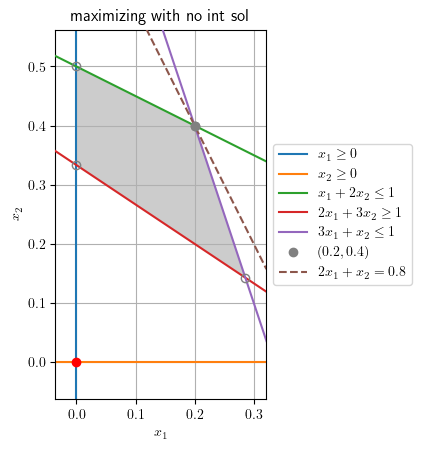

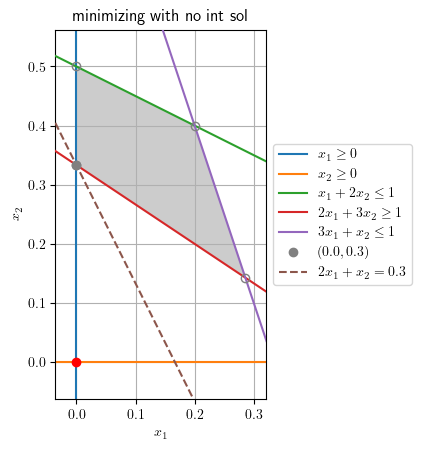

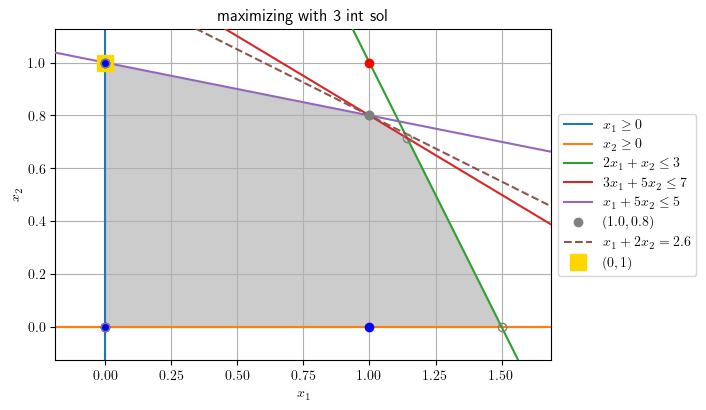

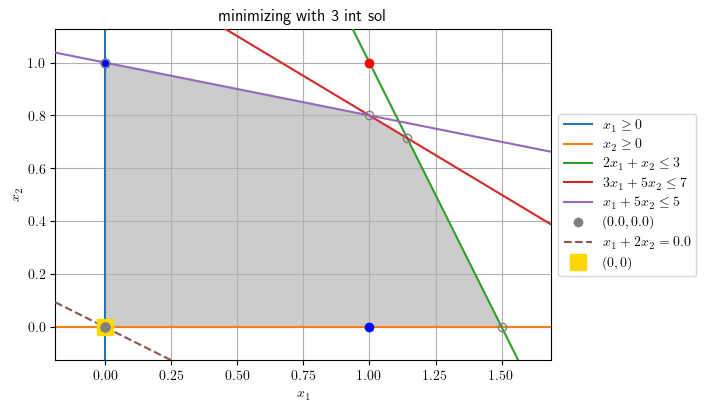

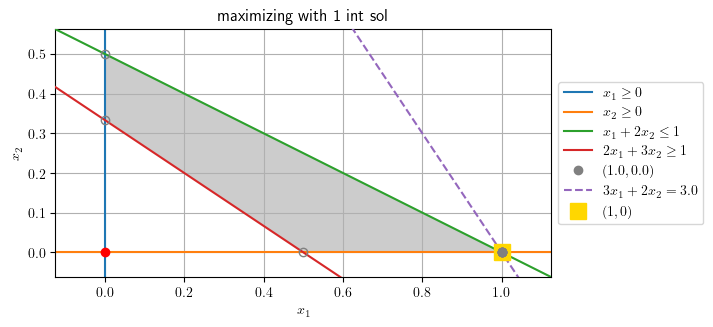

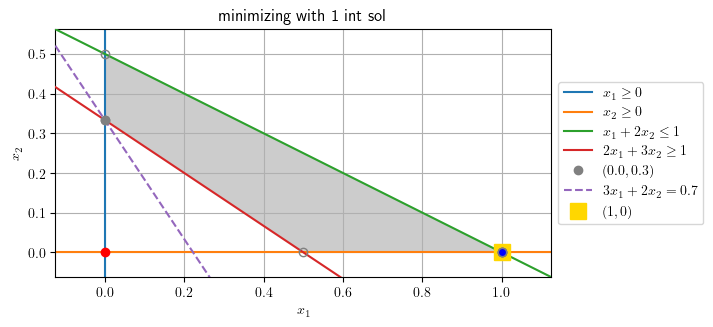

In [15]:
for m in models:
    milo.Draw(m,integer=True,isolines=False,title=m.name)

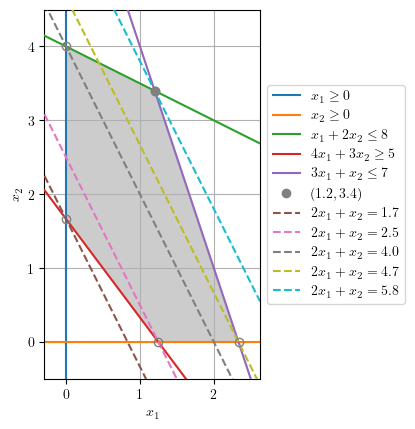

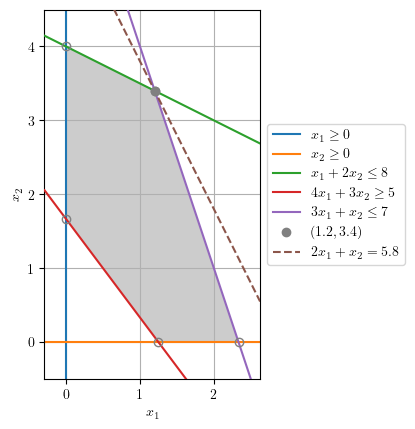

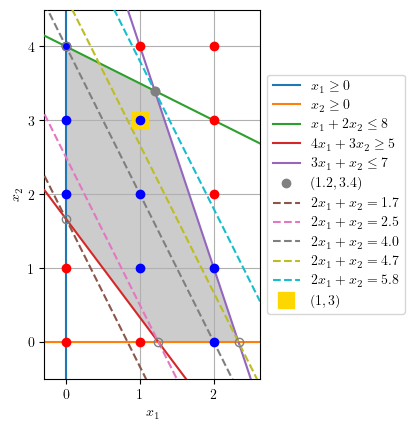

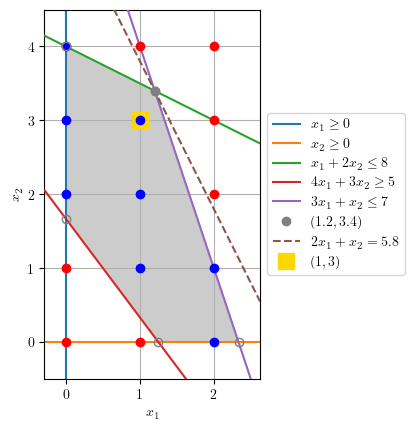

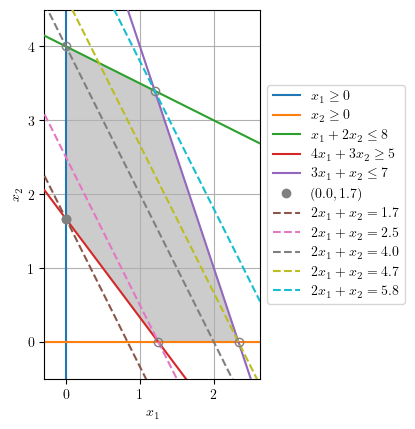

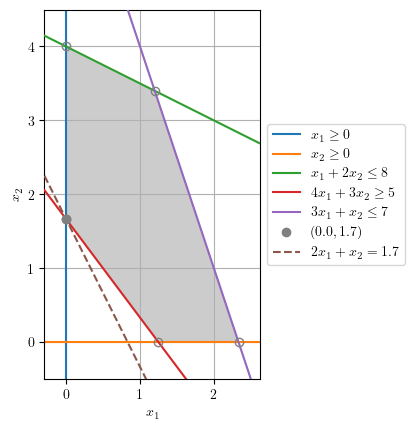

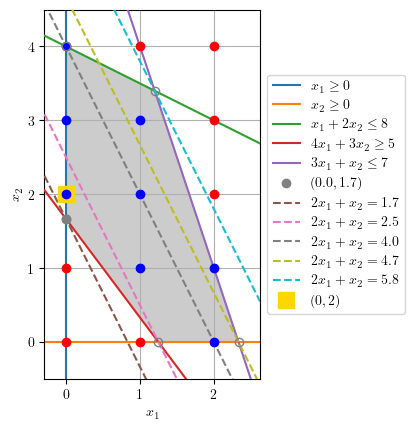

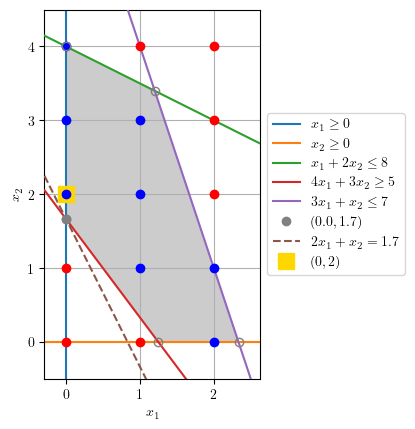

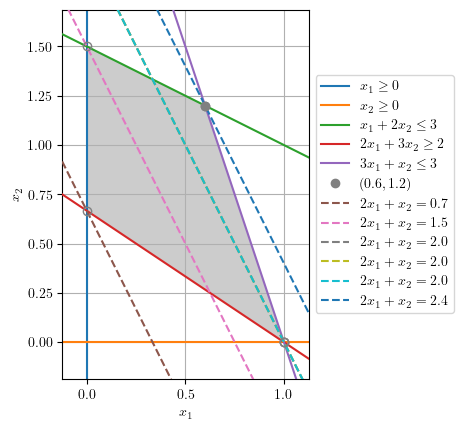

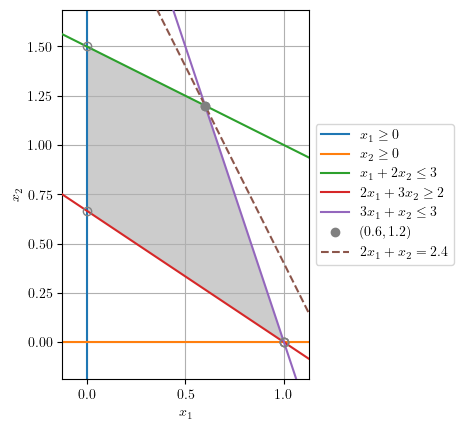

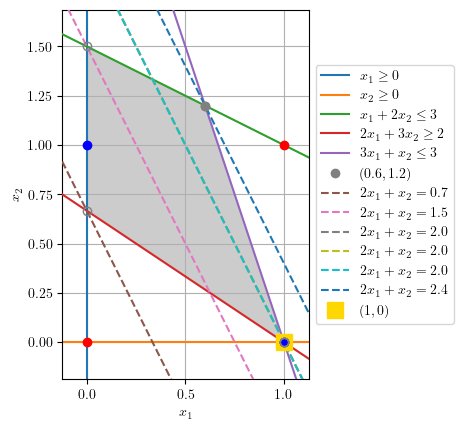

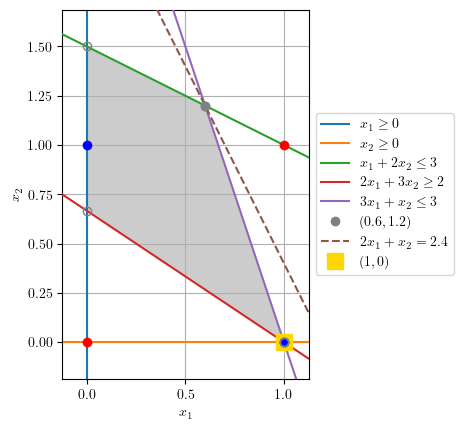

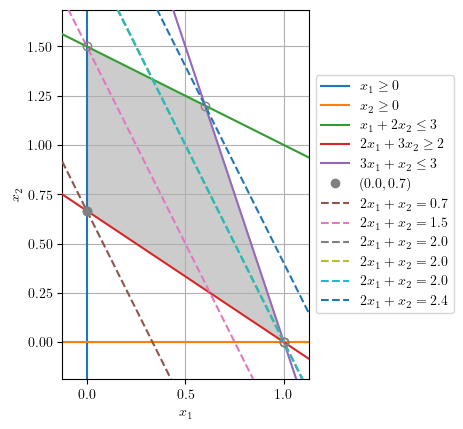

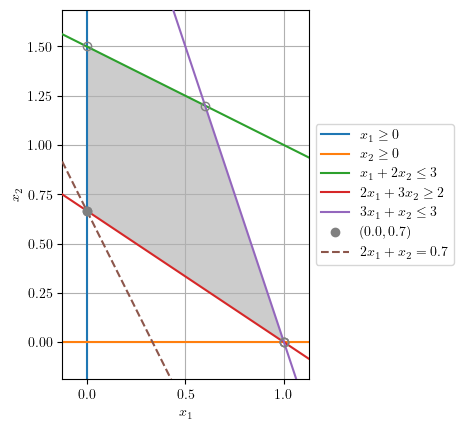

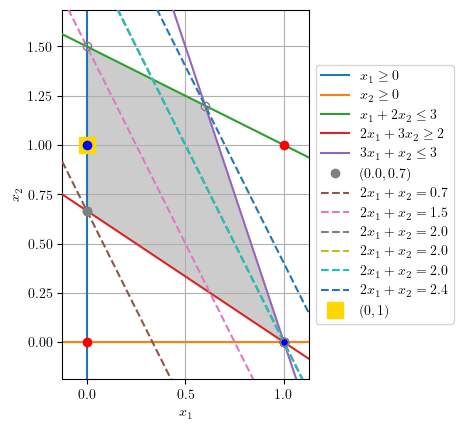

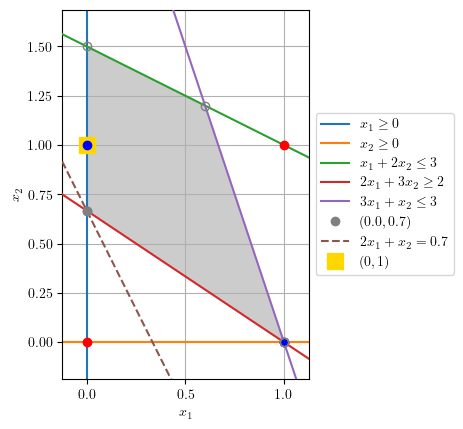

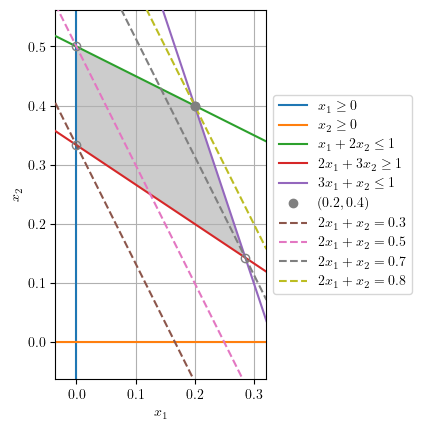

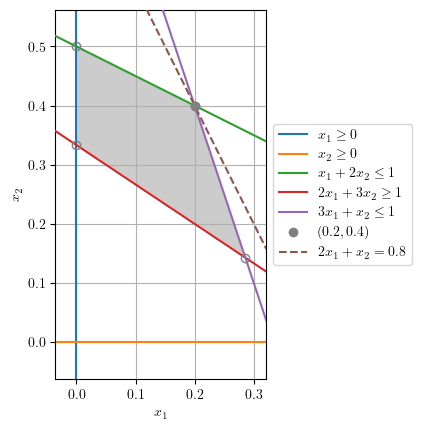

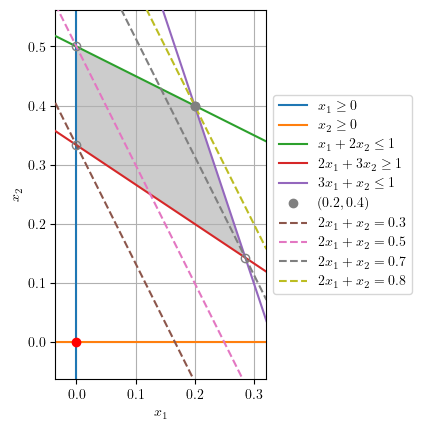

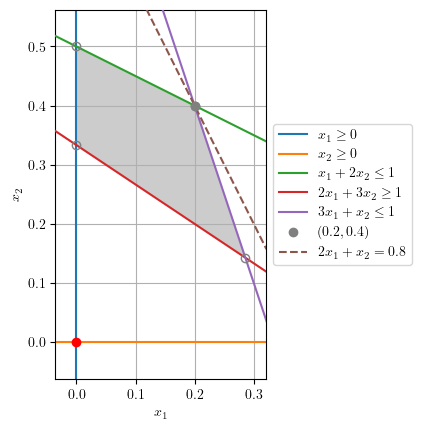

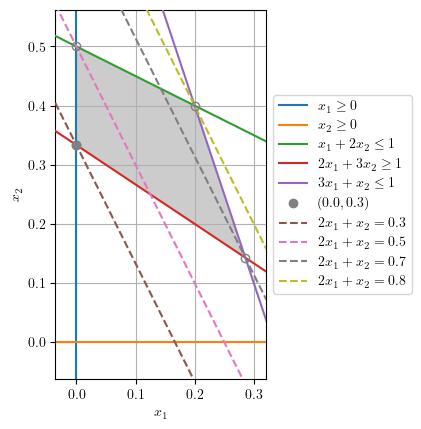

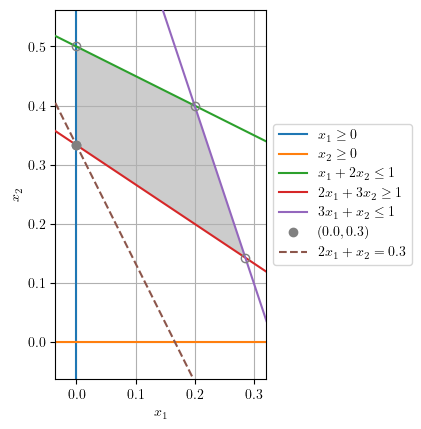

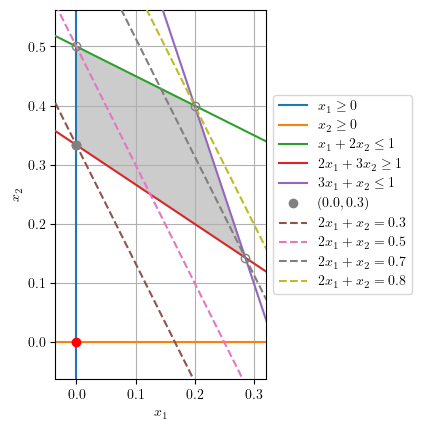

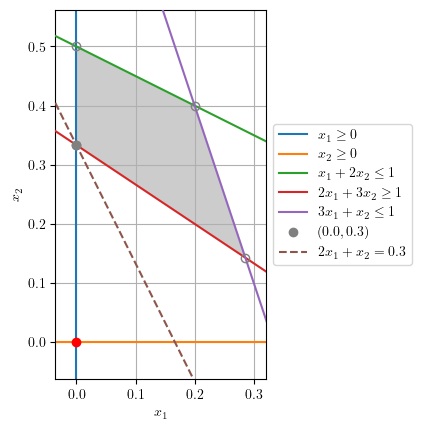

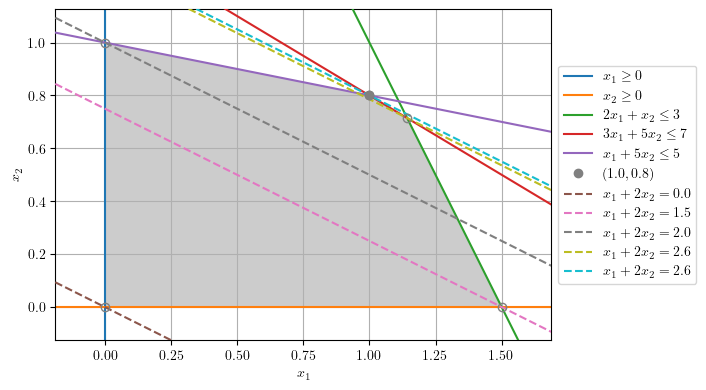

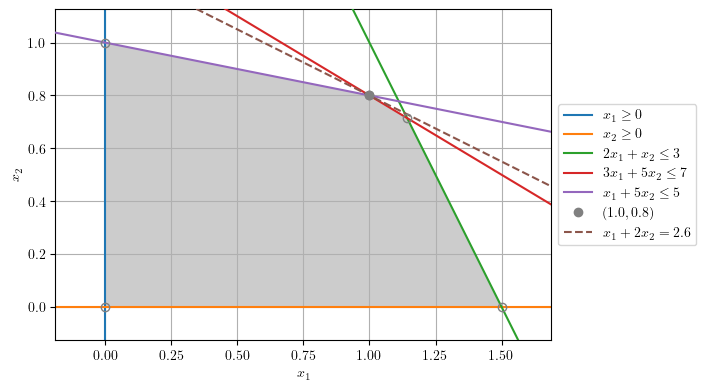

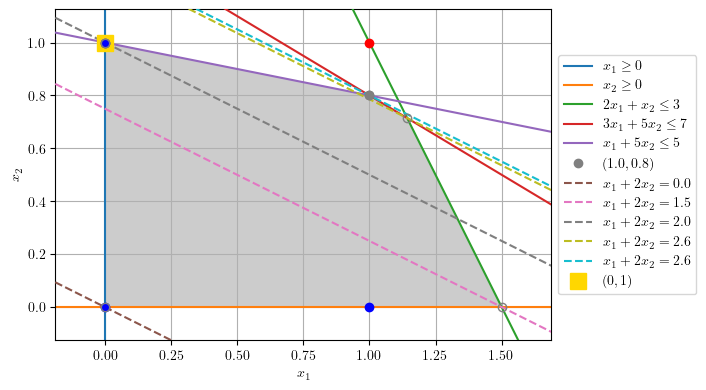

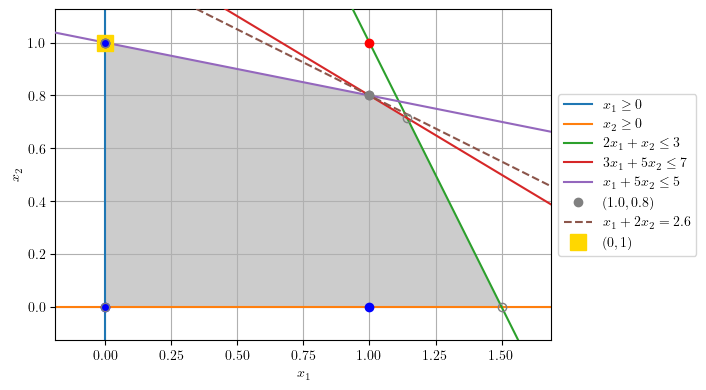

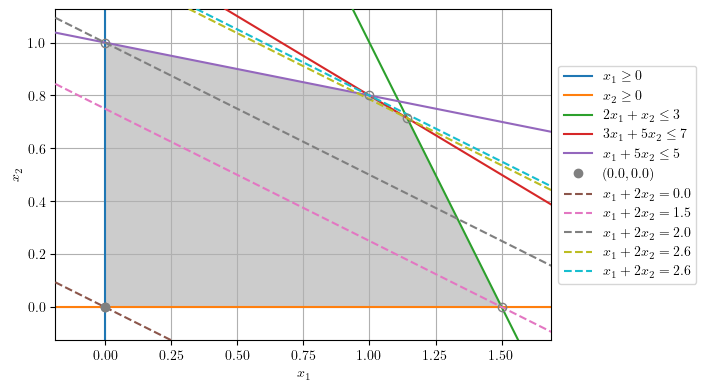

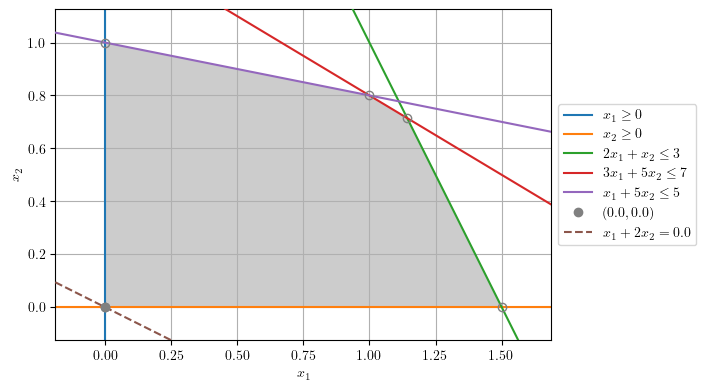

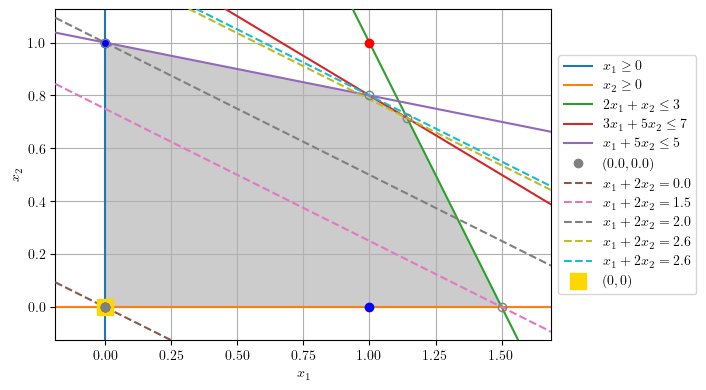

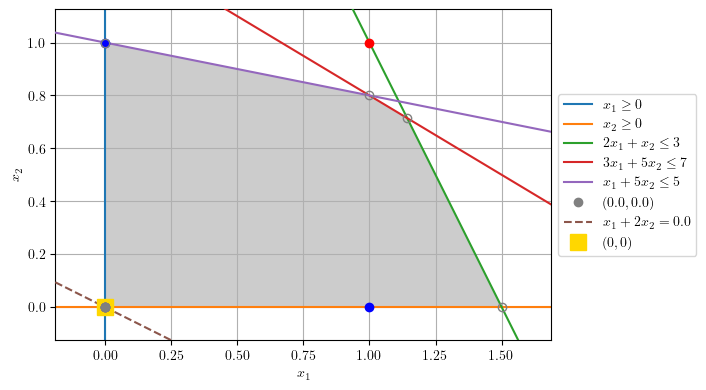

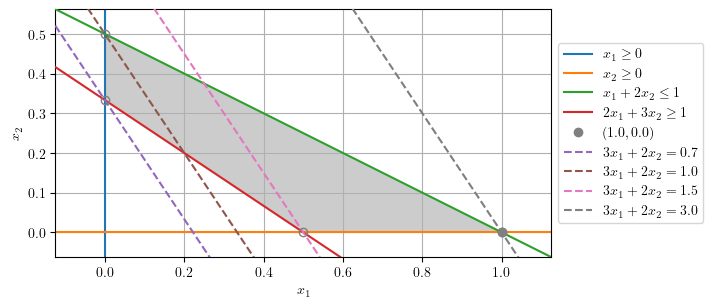

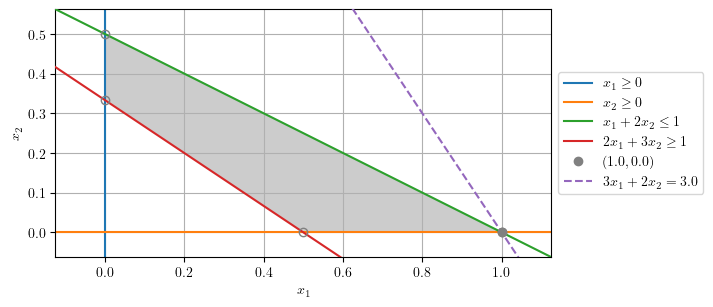

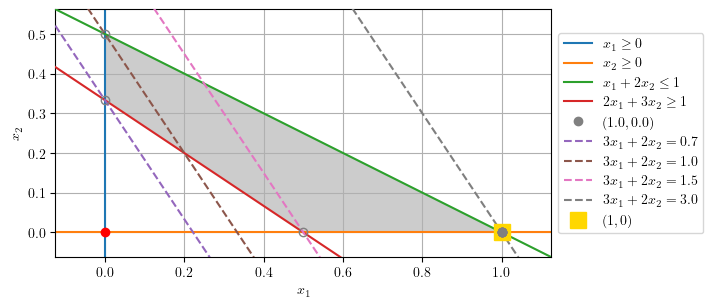

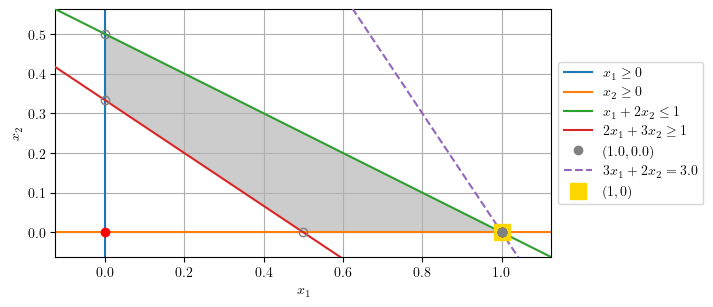

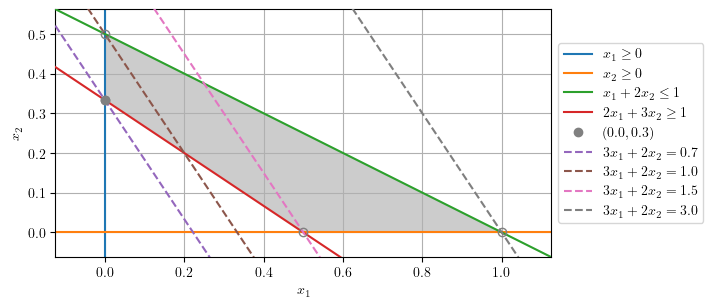

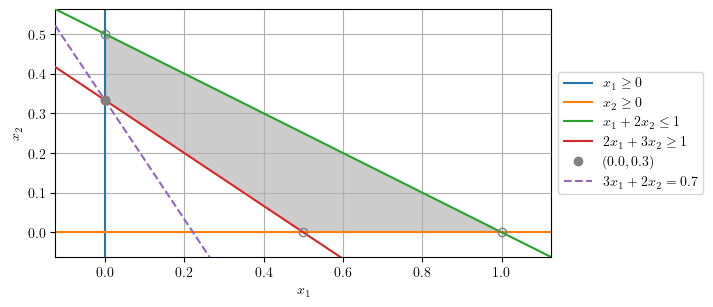

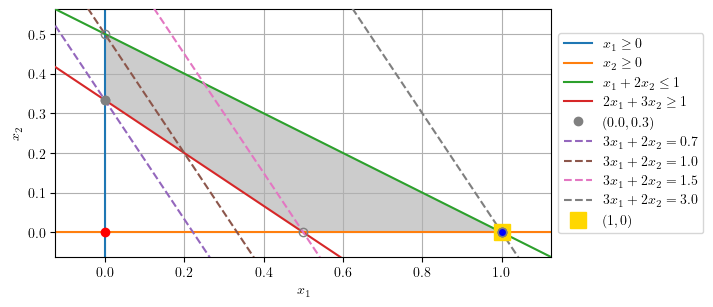

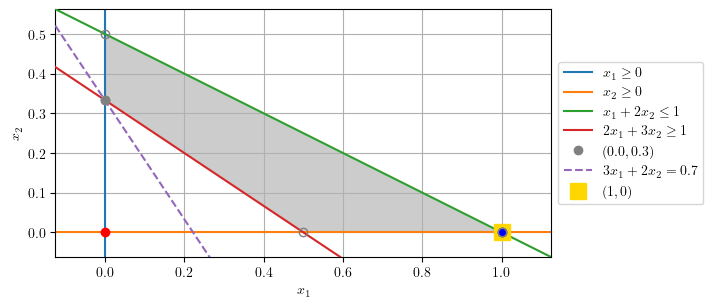

In [16]:
sections = []
for m in models:
    ThisModel(m)
    sections.append(Section(m))
    
with open(main_path+'all_milo.tex', "w") as tex_file:
    tex_file.write('\n'.join(sections))